In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

import PIL
import glob

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
rng = torch.Generator().manual_seed(137)

# Prepare dataset

## Download dataset

In [4]:
!pip install gdown

In [5]:
!gdown https://drive.google.com/uc?id=1QjTECPvkzrXUJxishXS-0KTknNq0erly

Downloading...
From (original): https://drive.google.com/uc?id=1QjTECPvkzrXUJxishXS-0KTknNq0erly
From (redirected): https://drive.google.com/uc?id=1QjTECPvkzrXUJxishXS-0KTknNq0erly&confirm=t&uuid=f5c3c8b8-6dc9-409c-b0a4-9336ced0a526
To: /content/gz_data.zip
100% 224M/224M [00:03<00:00, 62.7MB/s]


In [6]:
!unzip -q gz_data.zip

## Visualise data
Let's have a look at example images:

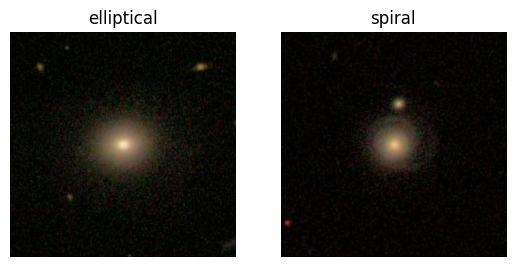

In [7]:
fig, ax = plt.subplots(ncols=2)
for s, a in zip(['elliptical', 'spiral'], ax) :
  a.imshow(PIL.Image.open(glob.glob(f'curated_data/{s}/*.jpg')[0]))
  a.set_title(s)
  a.axis('off')

## Preprocessing

Let's resize the dataset images to 64x64 pixels to make training CPU-friendly. If you run the code on GPU, you can omit the resizing line, or resize to, for example, 224x224 pixels.

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize for faster training
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values to [-1,1]
])
dataset = datasets.ImageFolder('curated_data', transform=transform)

## Splitting dataset

Let's split our data set into training, validation, and test data.

It's very important to do things reproducibly!

In [17]:
len_train = int(0.7*len(dataset))
len_valid = int(0.2*len(dataset))
len_test = len(dataset) - len_train - len_valid
trainset, validset, testset = torch.utils.data.random_split(
    dataset,
     [len_train, len_valid, len_test],
    generator=rng
)

In [18]:
print(f'Data set sizes:\n\ttraining:\t{len(trainset)}\n\tvalidation:\t{len(validset)}\n\ttesting:\t{len(testset)}')

Data set sizes:
	training:	11200
	validation:	3200
	testing:	1600


Now we have our data sets ready for further use.
Each data item consists of an RGB image at index 0
and a binary label (integer 0 or 1) at index 1.

In [19]:
print(f'Image size :{trainset[0][0].shape}')
print(f'Image size :{trainset[0][1]}')

Image size :torch.Size([3, 64, 64])
Image size :0


---
# Can MLP handle an image classification?

Let's first define a function that performs training and validation.

In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader

def train_model(
    model: nn.Module,
    trainset: torch.utils.data.Dataset,
    validset: torch.utils.data.Dataset,
    device: torch.device,
    batch_size: int = 64,
    epochs: int = 5,
    lr: float = 1e-3,
) -> None:
    """Train a PyTorch model on train/validation subsets.

    Args:
        model: The PyTorch model (nn.Module).
        trainset: Training dataset (Subset from ImageFolder).
        validset: Validation dataset (Subset from ImageFolder).
        device: Device to train on (cpu or cuda).
        batch_size: Batch size for DataLoader.
        epochs: Number of training epochs.
        lr: Learning rate for Adam optimizer.
    """
    # DataLoaders
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # --- Validation ---
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {running_loss/len(train_loader):.3f} | "
            f"Val Loss: {val_loss/len(valid_loader):.3f} | "
            f"Val Acc: {val_acc:.2f}%"
        )


Now, we'll try to train an MLP to classify galaxy images.

In [17]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(64*64*3, 512) # if you change the input image size, don't forget to adjust the layer parameter as well.
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
    x = x.view(x.size(0), -1) # flatten
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

mlp_model = MLP().to(device)
print("MLP parameters:", sum(p.numel() for p in mlp_model.parameters()))

MLP parameters: 6357890


In [29]:
mlp_model = MLP().to(device)
train_model(mlp_model, trainset, validset, device, epochs=5)

Epoch 1/5 | Train Loss: 0.755 | Val Loss: 0.663 | Val Acc: 60.09%
Epoch 2/5 | Train Loss: 0.585 | Val Loss: 0.601 | Val Acc: 67.78%
Epoch 3/5 | Train Loss: 0.532 | Val Loss: 0.644 | Val Acc: 62.53%
Epoch 4/5 | Train Loss: 0.508 | Val Loss: 0.494 | Val Acc: 78.47%
Epoch 5/5 | Train Loss: 0.497 | Val Loss: 0.507 | Val Acc: 76.53%


**TO-DO:**
1. Try to finetune the MLP architecture to get better results. Use the tricks you've learnt this week.
2. (Optional) Write a function that returns a vector of predictions on a given dataset (look how it is implemented in training function). Use this function to get predictions on validation dataset and build a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). [Visualize](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) the confusion matrix.
---

# Small CNN for image classification

In [18]:
class SmallCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(32*16*16, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    return self.fc2(x)

cnn_model = SmallCNN().to(device)
print("CNN parameters:", sum(p.numel() for p in cnn_model.parameters()))

CNN parameters: 1054050


In [30]:
cnn_model = SmallCNN().to(device)
train_model(cnn_model, trainset, validset, device, epochs=5)

Epoch 1/5 | Train Loss: 0.428 | Val Loss: 0.262 | Val Acc: 89.09%
Epoch 2/5 | Train Loss: 0.230 | Val Loss: 0.239 | Val Acc: 90.38%
Epoch 3/5 | Train Loss: 0.201 | Val Loss: 0.213 | Val Acc: 91.75%
Epoch 4/5 | Train Loss: 0.176 | Val Loss: 0.199 | Val Acc: 91.81%
Epoch 5/5 | Train Loss: 0.154 | Val Loss: 0.253 | Val Acc: 90.00%


**TO-DO:**
1. Try to understand the input size in each layer.
2. Finetune the CNN architecture to get better results.
3. Take a look at number of parameters of MLP and CNN models. Which architecture needs to train less parameters to achieve good performance?
4. (Optional) Augment the dataset by [rotation, scaling, flipping](https://docs.pytorch.org/vision/0.9/transforms.html). How does such a dataset preprocessing impact the model performance?
---

# Transfer learning with pretrained CNN

Let's use a pretrained feature extractor from a [ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/). We will use the feature extractor as it is, training only MLP layers for the classification.

In [31]:
import torch
import torch.nn as nn
from torchvision import models

class PretrainedFeatureExtractor(nn.Module):
    """Transfer learning model using a pretrained ResNet as feature extractor."""

    def __init__(self, num_classes: int = 2, freeze_extractor: bool = True):
        """
        Args:
            num_classes: Number of output classes.
            freeze_extractor: If True, freeze pretrained feature extractor.
        """
        super().__init__()

        # Load pretrained ResNet18
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Optionally freeze feature extractor
        if freeze_extractor:
            for param in backbone.parameters():
                param.requires_grad = False

        # Save backbone up to (but not including) the classifier head
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])  # everything except final FC

        # New classification head
        in_features = backbone.fc.in_features
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through feature extractor and classifier."""
        x = self.feature_extractor(x)       # shape: (batch, features, 1, 1)
        x = torch.flatten(x, 1)             # shape: (batch, features)
        return self.classifier(x)


In [32]:
# Create model (freeze extractor, train only classifier)
transfer_model = PretrainedFeatureExtractor(num_classes=2, freeze_extractor=True).to(device)
for param in transfer_model.feature_extractor[-2:].parameters():
    param.requires_grad = True

# Train it just like other models
train_model(transfer_model, trainset, validset, device, epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Epoch 1/5 | Train Loss: 0.485 | Val Loss: 0.428 | Val Acc: 82.16%
Epoch 2/5 | Train Loss: 0.410 | Val Loss: 0.438 | Val Acc: 80.81%
Epoch 3/5 | Train Loss: 0.398 | Val Loss: 0.408 | Val Acc: 83.03%
Epoch 4/5 | Train Loss: 0.396 | Val Loss: 0.446 | Val Acc: 80.94%
Epoch 5/5 | Train Loss: 0.389 | Val Loss: 0.414 | Val Acc: 82.81%


**TO-DO:**
1. How does the performance of pretrained model compares to the performance of the CNN fully trained on galaxy dataset? Any ideas about the reasons of such behaviour?
2. Let's unfreeze the last layers of feature extractor and learn their weights as well. Did the performance change?

In [33]:
# Create model (train last layers of feature exptractor and classifier)
transfer_model = PretrainedFeatureExtractor(num_classes=2, freeze_extractor=True).to(device)
for param in transfer_model.feature_extractor[-2:].parameters(): # you can adjust the number of layers to unfreeze
    param.requires_grad = True

# Train it just like other models
train_model(transfer_model, trainset, validset, device, epochs=5)

Epoch 1/5 | Train Loss: 0.263 | Val Loss: 0.179 | Val Acc: 93.12%
Epoch 2/5 | Train Loss: 0.133 | Val Loss: 0.178 | Val Acc: 93.38%
Epoch 3/5 | Train Loss: 0.095 | Val Loss: 0.176 | Val Acc: 93.50%
Epoch 4/5 | Train Loss: 0.070 | Val Loss: 0.211 | Val Acc: 92.41%
Epoch 5/5 | Train Loss: 0.063 | Val Loss: 0.225 | Val Acc: 92.59%


---
# GNN for image classification

The simplest way to deal with images is to represent then as a following graph: each pixel is a graph node, described by a color channel vector. Each pixel/node is connected with 8 neighbours.

The issue of such representation is the graph size. Even with images resized to 64x64 pixels, the graph will have ~4k nodes and ~30k edges.

Another approach is to apply an computer vision algorithm that extracts key points from images and use them as graph nodes. This goes beyond the scope of the course.

---
# GNN for cosmo data

Instead of galaxy image classification, you can take a look at this [tutorial](https://colab.research.google.com/github/jwuphysics/LSSTC-DSFP-Session-19/blob/main/day4/Graph%20Neural%20Networks.ipynb).

---
# Transformers time

In [12]:
import math

def get_sinusoidal_encoding(n_positions: int, dim: int) -> torch.Tensor:
    """Generate sinusoidal positional encodings (fixed).
    Args:
        n_positions: number of positions (num_patches + 1 for CLS).
        dim: embedding dimension.
    Returns:
        Tensor of shape (1, n_positions, dim)
    """
    position = torch.arange(n_positions).unsqueeze(1)  # (n_positions, 1)
    div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
    pe = torch.zeros(n_positions, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # (1, n_positions, dim)


class SmallViT(nn.Module):
    def __init__(
        self,
        image_size=64,
        patch_size=8,
        in_channels=3,
        num_classes=2,
        dim=128,
        depth=4,
        heads=4,
        mlp_dim=256,
        positional_encoding: str = "learned",  # "learned" or "fixed"
    ):
        super().__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        self.patch_size = patch_size
        self.dim = dim
        self.num_patches = num_patches

        # Patch embedding
        self.to_patch_embedding = nn.Linear(patch_dim, dim)

        # CLS token (always learned)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Positional encoding
        if positional_encoding == "learned":
            self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, dim))
            nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        elif positional_encoding == "fixed":
            self.register_buffer("pos_embedding", get_sinusoidal_encoding(num_patches + 1, dim))
        else:
            raise ValueError("positional_encoding must be 'learned' or 'fixed'")

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size

        # Create patches
        x = x.unfold(2, p, p).unfold(3, p, p)  # (B, C, H//p, W//p, p, p)
        x = x.contiguous().view(B, C, -1, p, p).permute(0, 2, 1, 3, 4)  # (B, num_patches, C, p, p)
        x = x.flatten(2)  # (B, num_patches, patch_dim)
        x = self.to_patch_embedding(x)

        # Add cls token
        cls_tokens = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional encoding
        x = x + self.pos_embedding[:, :x.size(1), :]

        # Transformer
        x = self.transformer(x)

        # Classification (use CLS token)
        cls_out = x[:, 0]
        return self.mlp_head(cls_out)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = SmallViT(image_size=64, patch_size=8, positional_encoding="learned").to(device)
train_model(vit_model, trainset, validset, device, batch_size=32, epochs=5)

Epoch 1/5 | Train Loss: 0.685 | Val Loss: 0.595 | Val Acc: 69.50%
Epoch 2/5 | Train Loss: 0.522 | Val Loss: 0.602 | Val Acc: 66.75%
Epoch 3/5 | Train Loss: 0.557 | Val Loss: 0.605 | Val Acc: 71.69%
Epoch 4/5 | Train Loss: 0.591 | Val Loss: 0.687 | Val Acc: 54.25%
Epoch 5/5 | Train Loss: 0.573 | Val Loss: 0.703 | Val Acc: 55.94%


**TO-DO:**
1. Try to understand the transformer network parameters. Once done, it's time for fine-tuning.
2. Take a look at "positional_encoding" parameter. Switch it to "fixed" (in this case the encoding will be done in the same way as for text) and look at the change in the performance. Can you explain this change? Think about other way of positional encoding that could be useful there and try it out.